In [35]:
import gymnasium as gym
import gym_trading_env
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from copy import copy
from copy import deepcopy
import talib
from gym_trading_env.renderer import Renderer
from collections import deque
from torch import optim

In [36]:
nifty50_index_symbol = '^NSEI'

start_date = '2010-01-01'
end_date = '2019-06-30'
# end_date = '2012-06-11'

data = yf.download(nifty50_index_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [37]:
df = data

In [38]:
df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)

In [39]:
df['feature-MACD'], df['feature-MACD_signal'], df['feature-MACD_hist'] = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)

df['feature-RSI'] = talib.RSI(df['close'], timeperiod=14)

df['feature-CCI'] = talib.CCI(df['high'], df['low'], df['close'], timeperiod=14)

df['feature-ADX'] = talib.ADX(df['high'], df['low'], df['close'], timeperiod=14)

df.dropna(inplace = True)


In [40]:
df.head()

,open,high,low,close,Adj Close,volume,feature-MACD,feature-MACD_signal,feature-MACD_hist,feature-RSI,feature-CCI,feature-ADX
Date,,,,,,,,,,,,
2010-02-22,4849.350098,4912.049805,4845.899902,4856.399902,4856.399902,0,-109.548259,-154.744720,45.196460,43.139037,54.461887,48.152569
2010-02-23,4856.600098,4884.100098,4833.149902,4870.049805,4870.049805,0,-100.382758,-143.872327,43.489569,44.442825,42.100457,46.773543
2010-02-24,4869.549805,4880.549805,4834.649902,4858.600098,4858.600098,0,-92.971214,-133.692104,40.720891,43.540963,42.965528,45.493020
2010-02-25,4859.000000,4880.149902,4835.600098,4859.750000,4859.750000,0,-86.013217,-124.156327,38.143110,43.664606,45.740310,44.303962
2010-02-26,4858.500000,4992.000000,4858.450195,4922.299805,4922.299805,0,-74.591859,-114.243433,39.651574,50.070038,135.781805,41.306797


In [41]:
action_space = np.linspace(0, 1, num=11).tolist()

for i in range(len(action_space)):
    action_space[i] = round(action_space[i], 1)

In [42]:
action_space

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [43]:
env = gym.make("TradingEnv",
        name= "RL",
        df = df,
        positions =action_space , # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        # trading_fees = 0.01/100, # 0.01% per stock buy / sell
        # borrow_interest_rate= 0.0003/100, # 0.0003% per timestep 
    )

In [44]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def ppo_loss(old_probs, new_probs, advantages, epsilon=0.2):
    ratio = new_probs / (old_probs + 1e-8)
    clipped_ratio = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
    return -torch.min(ratio * advantages, clipped_ratio * advantages).mean()


In [45]:
def run_simulation(policy_model):
    policy_model.eval()

    done, truncated = False, False
    curr_state, info = env.reset()
    total_reward = 0
    action_history = []
    action_count = [0, 0, 0]

    while not done and not truncated:
        curr_state_tensor = torch.Tensor(curr_state).unsqueeze(0)  # Convert to tensor and add batch dimension
        with torch.no_grad():  # No gradient calculation needed for evaluation
            probs = policy_model(curr_state_tensor)  # Get policy output
        action_probs = torch.softmax(probs, dim=-1).numpy()  # Compute action probabilities

        # Choose action based on the highest probability (deterministic policy)
        action = np.argmax(action_probs[0])
        
        next_state, reward, done, truncated, info = env.step(action)
        total_reward += reward
        
        action_history.append(action)
        
        # Record the count of different actions (optional, for analysis)
        if action < 5:
            action_count[0] += 1
        elif action > 5:
            action_count[2] += 1
        else:
            action_count[1] += 1

        curr_state = next_state

    # Save render logs if needed (adjust the directory path as required)
    env.unwrapped.save_for_render(dir="render_logs")
    print("Action History:", action_history)
    print("Total Reward:", total_reward)
    print("Action Count:", action_count)

    return (info['portfolio_valuation'] - 1000)/10

In [46]:
# Initialize networks and optimizers
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy_net = PolicyNetwork(state_dim, action_dim)
value_net = ValueNetwork(state_dim)

policy_optimizer = optim.Adam(list(policy_net.parameters()), lr=3e-4)
value_optimizer = optim.Adam(list(value_net.parameters()), lr=1e-3)


In [47]:
policy_net.load_state_dict(torch.load('ppo_policy_model_weights.pth', weights_only = True))
value_net.load_state_dict(torch.load('ppo_value_model_weights.pth', weights_only = True))

<All keys matched successfully>

In [48]:
buffer_size = 1000
buffer = []
buffer = deque(maxlen=buffer_size)
epsilon = 0.2  # PPO clipping parameter
max_iters = 100000
gamma = 0.95
policy_loss_history = []
value_loss_history = []
rewards_history = []
test_return_pc_history = []

In [56]:
policy_net.train()
value_net.train()
for i in range(max_iters):
    action_history = []
    action_count = [0, 0, 0]
    done, truncated = False, False
    curr_state, info = env.reset()
    rewards_sum = 0
    count_explore_exploit = [0, 0]
    
    while not done and not truncated:
        curr_state_tensor = torch.Tensor(curr_state).unsqueeze(0)
        with torch.no_grad():
            probs = policy_net(curr_state_tensor)
        action_probs = torch.softmax(probs, dim=-1).numpy()
        rand_num = np.random.uniform(0, 1)
        if rand_num < epsilon:
            action = np.random.choice(action_dim)
            count_explore_exploit[0] += 1
        else:
            action = np.random.choice(action_dim, p=action_probs[0])
            count_explore_exploit[1] += 1
        
        next_state, reward, done, truncated, info = env.step(action)
        rewards_sum += reward
        
        action_history.append(action)

        if action < 5:
            action_count[0] += 1
        elif action > 5:
            action_count[2] += 1
        else:
            action_count[1] += 1

        buffer.append((curr_state, action, reward, next_state, done, truncated))
        if len(buffer) > buffer_size:
            buffer.popleft()
        
        curr_state = next_state
    
    rewards_history.append(rewards_sum)
    
    # Sample from buffer
    sample_indices = np.random.choice(len(buffer), size=min(400, len(buffer)), replace=False)
    train_sample = [buffer[idx] for idx in sample_indices]

    states, actions, rewards, next_states, dones, truncateds = zip(*train_sample)

    # Convert lists to NumPy arrays
    states_np = np.array(states)
    actions_np = np.array(actions)
    rewards_np = np.array(rewards)
    next_states_np = np.array(next_states)
    dones_np = np.array(dones)

    # Convert NumPy arrays to PyTorch tensors
    states = torch.tensor(states_np, dtype=torch.float32)
    actions = torch.tensor(actions_np, dtype=torch.long)
    rewards = torch.tensor(rewards_np, dtype=torch.float32)
    next_states = torch.tensor(next_states_np, dtype=torch.float32)
    dones = torch.tensor(dones_np, dtype=torch.float32)

    # Compute advantages and targets
    values = value_net(states).squeeze()
    next_values = value_net(next_states).squeeze()
    advantages = rewards + gamma * next_values - values
    target_values = rewards + gamma * next_values
    
    # Update policy network
    old_probs = torch.softmax(policy_net(states), dim=-1).gather(1, actions.unsqueeze(1)).squeeze()
    new_probs = torch.softmax(policy_net(states), dim=-1).gather(1, actions.unsqueeze(1)).squeeze()
    
    policy_optimizer.zero_grad()
    policy_loss = ppo_loss(old_probs, new_probs, advantages)
    policy_loss.backward(retain_graph=True)
    policy_optimizer.step()

    # Update value network
    value_optimizer.zero_grad()
    value_loss = (values - target_values).pow(2).mean()
    value_loss.backward(retain_graph=True)
    value_optimizer.step()

    policy_loss_history.append(policy_loss.item())
    value_loss_history.append(value_loss.item())

    print(i, "-> POLICY LOSS:", policy_loss.item(), "-> VALUE LOSS:", value_loss.item(), "-> REWARD:", rewards_sum, "\n-> Actions:", action_history[:20])
    print("Action Count", action_count, "Exploration COUNT", count_explore_exploit)

    if i % 50 == 0:
        print("----------SIMULATION-START----------")
        test_return_pc_history.append(run_simulation(policy_net))

        print("----------SIMULATION-END----------")

Market Return : 142.75%   |   Portfolio Return : 91.06%   |   
0 -> POLICY LOSS: -3.6804474802920595e-05 -> VALUE LOSS: 7.3850478656822816e-06 -> REWARD: 0.6474329425346914 
-> Actions: [8, 8, 4, 8, 8, 8, 10, 10, 8, 8, 5, 8, 8, 8, 10, 5, 10, 10, 10, 10]
Action Count [580, 64, 1643] Exploration COUNT [432, 1855]
----------SIMULATION-START----------
Market Return : 142.75%   |   Portfolio Return : 152.50%   |   
Action History: [8, 8, 8, 8, 10, 10, 10, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 7, 9, 10, 10, 10, 10, 1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1, 4, 10, 4, 4, 10, 7, 7, 7, 7, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 7, 7, 7, 10, 7, 10, 10, 10, 10, 10, 10, 10, 7, 7, 7, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 7, 10, 10, 2, 2, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 4, 4, 7, 7, 7, 7, 4,

In [50]:
torch.save(policy_net.state_dict(), 'ppo_policy_model_weights.pth')
torch.save(value_net.state_dict(), 'ppo_value_model_weights.pth')

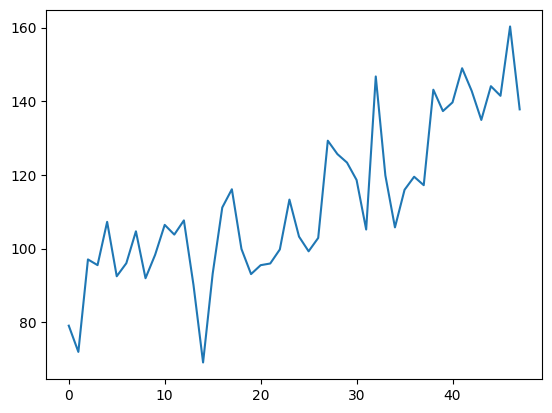

In [51]:
plt.plot(test_return_pc_history)

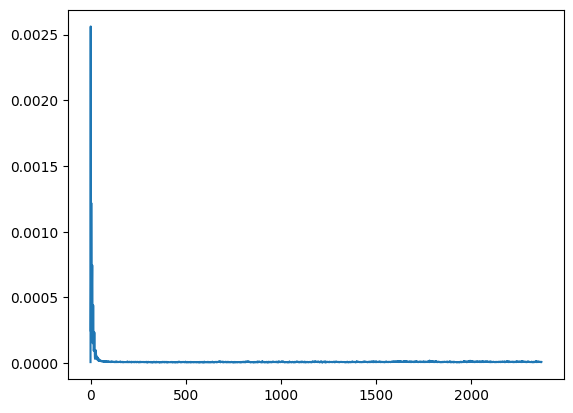

In [52]:
plt.plot(value_loss_history)

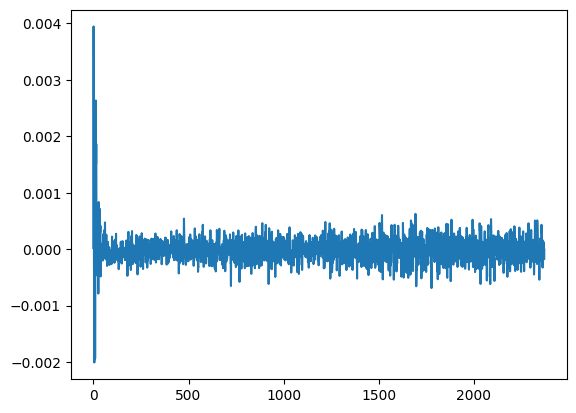

In [53]:
plt.plot(policy_loss_history)

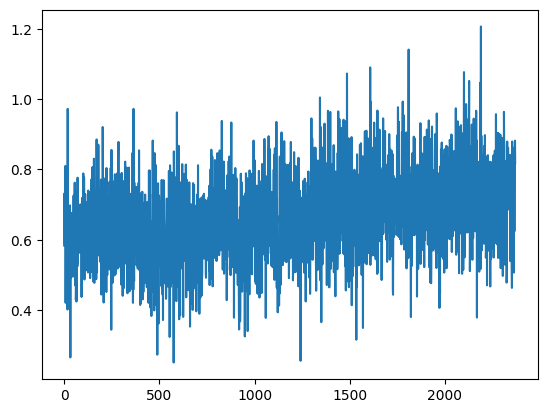

In [54]:
plt.plot(rewards_history)

In [55]:
run_simulation(policy_net)

Market Return : 142.75%   |   Portfolio Return : 156.64%   |   
Action History: [8, 8, 8, 8, 10, 10, 10, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 2, 9, 10, 10, 10, 10, 1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1, 4, 10, 4, 4, 10, 7, 7, 7, 7, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 7, 7, 7, 10, 7, 10, 10, 10, 10, 10, 10, 10, 7, 7, 7, 10, 10, 10, 10, 10, 10, 8, 10, 8, 10, 7, 10, 10, 2, 2, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 4, 4, 7, 7, 7, 7, 4, 4, 4, 4, 7, 7, 4, 4, 4, 10, 4, 4, 4, 4, 10, 10, 10, 10, 10, 7, 7, 7, 2, 9, 10, 1, 4, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 8, 10, 10, 7, 2, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

156.63580408627587

In [ ]:
# renderer = Renderer(render_logs_dir="render_logs")
# renderer.run()